# Time Series Segmentation Benchmark Evaluation
In this notebook, we evaluate the ClaSP algorithm on the <a href="https://github.com/ermshaua/time-series-segmentation-benchmark" target="_blank">"Time Series Segmentation Benchmark"</a> (TSSB). It currently contains 75 annotated TS with 1-9 segments. Each TS is constructed from one of the <a href="http://timeseriesclassification.com/" target="_blank">UEA & UCR time series classification datasets</a>. To do this, we grouped TS by label and concatenated them to create segments with distinctive temporal patterns and statistical properties. We annotated the offsets at which we concatenated the segments as CPs. Addtionally, resampling was applied to control the data set resolution.

In [1]:
import time

import daproli as dp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from claspy.data_loader import load_tssb_dataset
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.tests.evaluation import covering

In the ClaSPy package, we provide access to the TSSB via a data loader. We first load the annoatated benchmark as a pandas DataFrame.

In [2]:
df = load_tssb_dataset()
df.head()

,dataset,window_size,cps,time_series
0,Adiac,10,"[572, 1012, 1232]","[1.681146, 1.383394, 1.029389, 0.688386, 0.354..."
1,ArrowHead,10,[753],"[-1.957721, -1.858082, -1.657983, -1.420794, -..."
2,Beef,50,[705],"[-0.380818, -0.352238, -0.295392, -0.225041, -..."
3,BeetleFly,10,[1280],"[1.114805, 0.774403, 0.477129, 0.115781, -0.24..."
4,BirdChicken,20,[1280],"[1.697714, 1.439032, 1.22287, 0.99708, 0.76479..."


In order to benchmark the ClaSP algorithm on TSSB, we must use evaluation measures that quantify the quality of predicted segmentations. We implement common segmentation metrics such as Covering and F1-score, see the <a href="https://doi.org/10.1007/s10618-023-00923-x" target="_blank">ClaSP publication<a> for more details. We measure Covering and runtime in this evaluation in parallel using 4 processes with the <a href="https://github.com/ermshaua/daproli" target="_blank">daproli</a> package.

In [3]:
def evaluate_clasp(time_series, change_points):
    runtime = time.process_time()
    predictions = BinaryClaSPSegmentation().fit_predict(time_series)
    runtime = time.process_time() - runtime
    score = covering({0: change_points}, predictions, time_series.shape[0])
    return np.round(score, 3), np.round(runtime, 3)

In [4]:
results = dp.map(lambda _, row: (row.dataset, *evaluate_clasp(row.time_series, row.cps)), df.iterrows(), ret_type=list,
                 n_jobs=4, verbose=1)
results = pd.DataFrame.from_records(results, columns=["dataset", "covering_score", "runtime"])
results

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/ermshaua/miniconda3/envs/claspy/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8509: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Users/ermshaua/miniconda3/envs/claspy/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8509: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
/Users/ermshaua/miniconda3/envs/claspy/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8509: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  2.0min finished


,dataset,covering_score,runtime
0,Adiac,0.807,10.330
1,ArrowHead,0.985,10.265
2,Beef,0.973,10.194
3,BeetleFly,0.975,10.657
4,BirdChicken,0.994,0.600
...,...,...,...
70,UWaveGestureLibraryX,0.987,0.942
71,UWaveGestureLibraryY,0.963,0.935
72,UWaveGestureLibraryZ,0.810,0.877
73,WordSynonyms,0.727,0.403


Let's first review summary statistcs (mean, median, std deviation) for Covering performance as well as the total runtime for processing TSSB. Covering is measured between 0 ... 1 with higher being better.

In [5]:
print(
    f"Mean/Median/Std Covering: {np.round(results.covering_score.mean(), 3)}/{results.covering_score.median()}/{np.round(results.covering_score.std(), 3)}")
print(f"Total runtime (in seconds): {results.runtime.sum()}")

Mean/Median/Std Covering: 0.855/0.961/0.19
Total runtime (in seconds): 312.96400000000006


To get an intuition of the performance, we investigate 5 random segmentations.

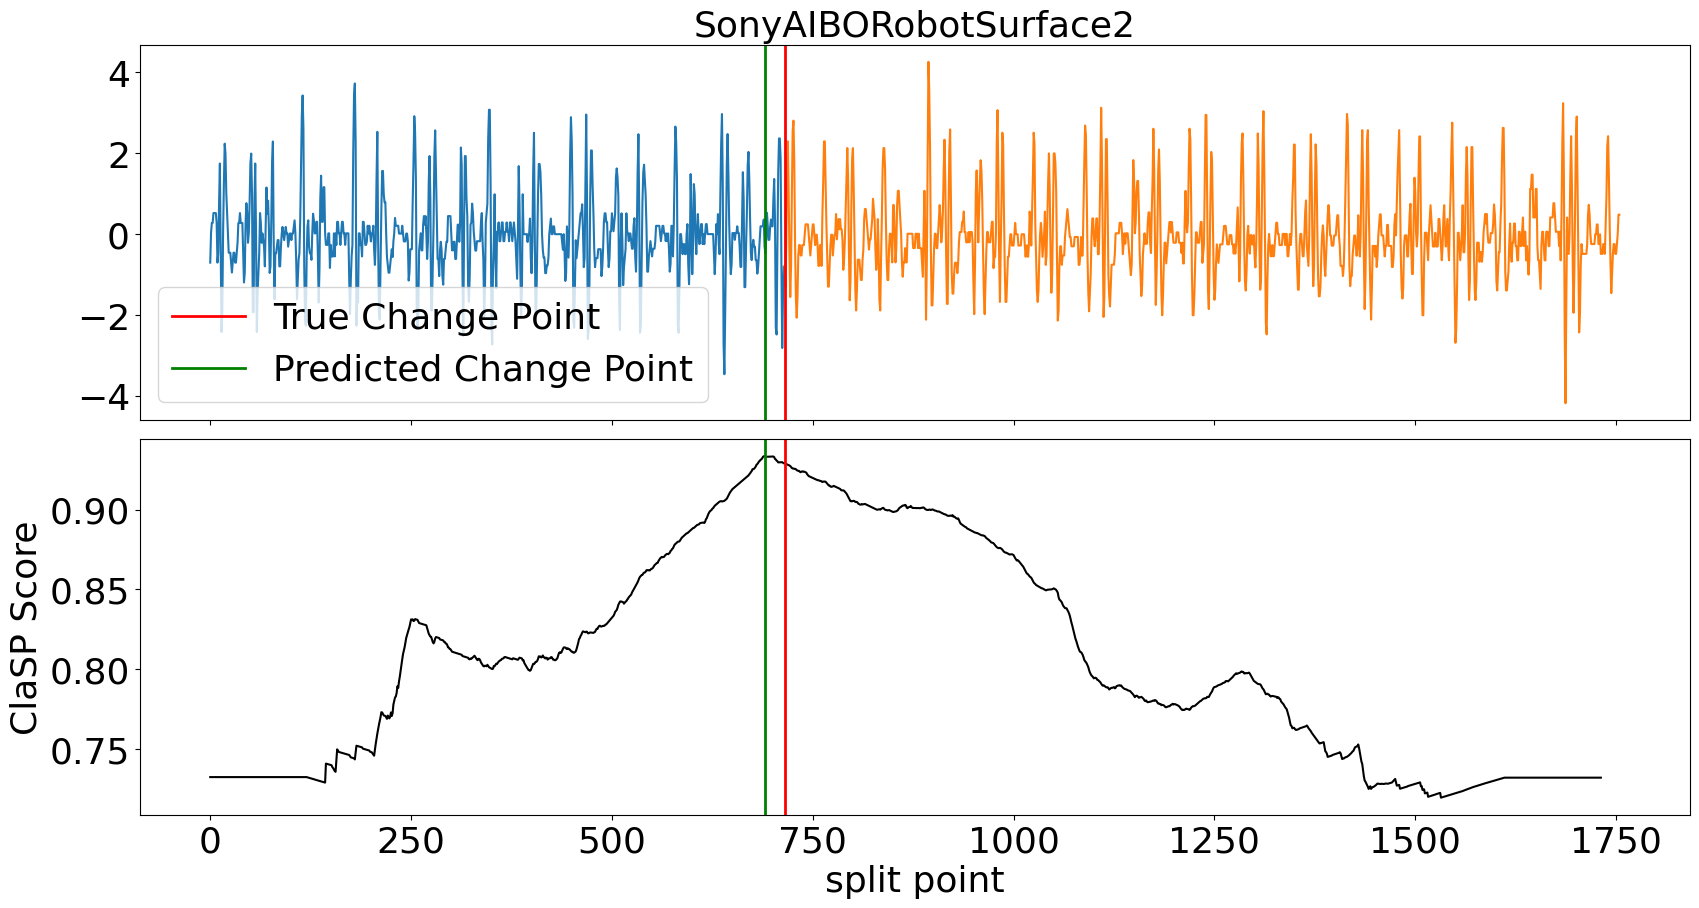

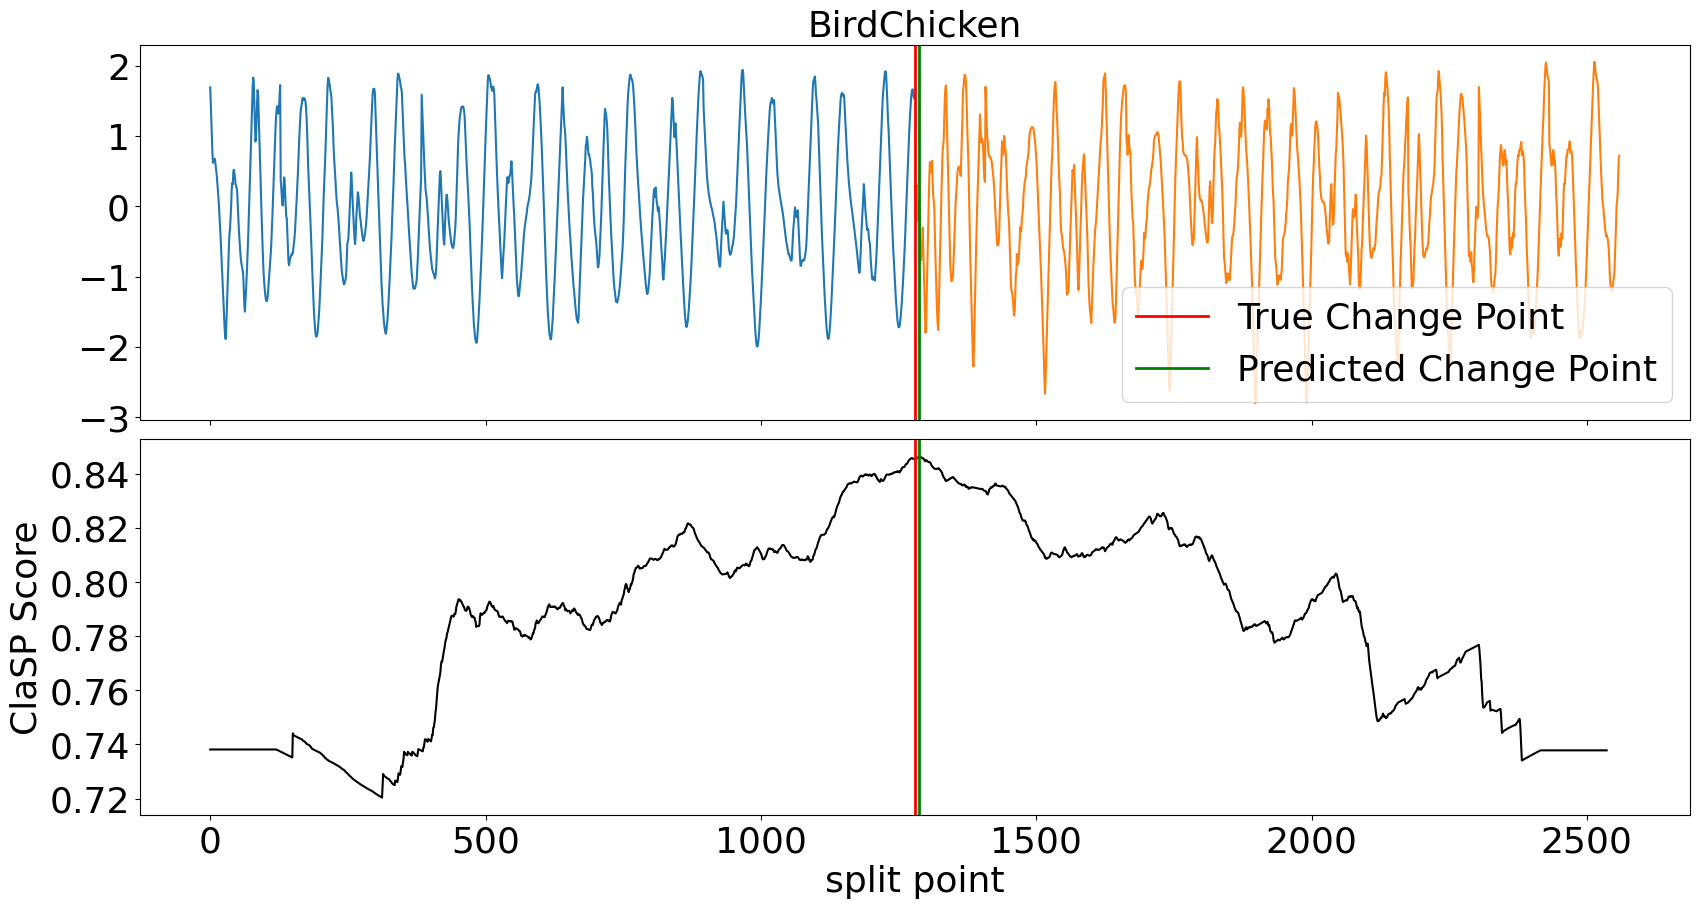

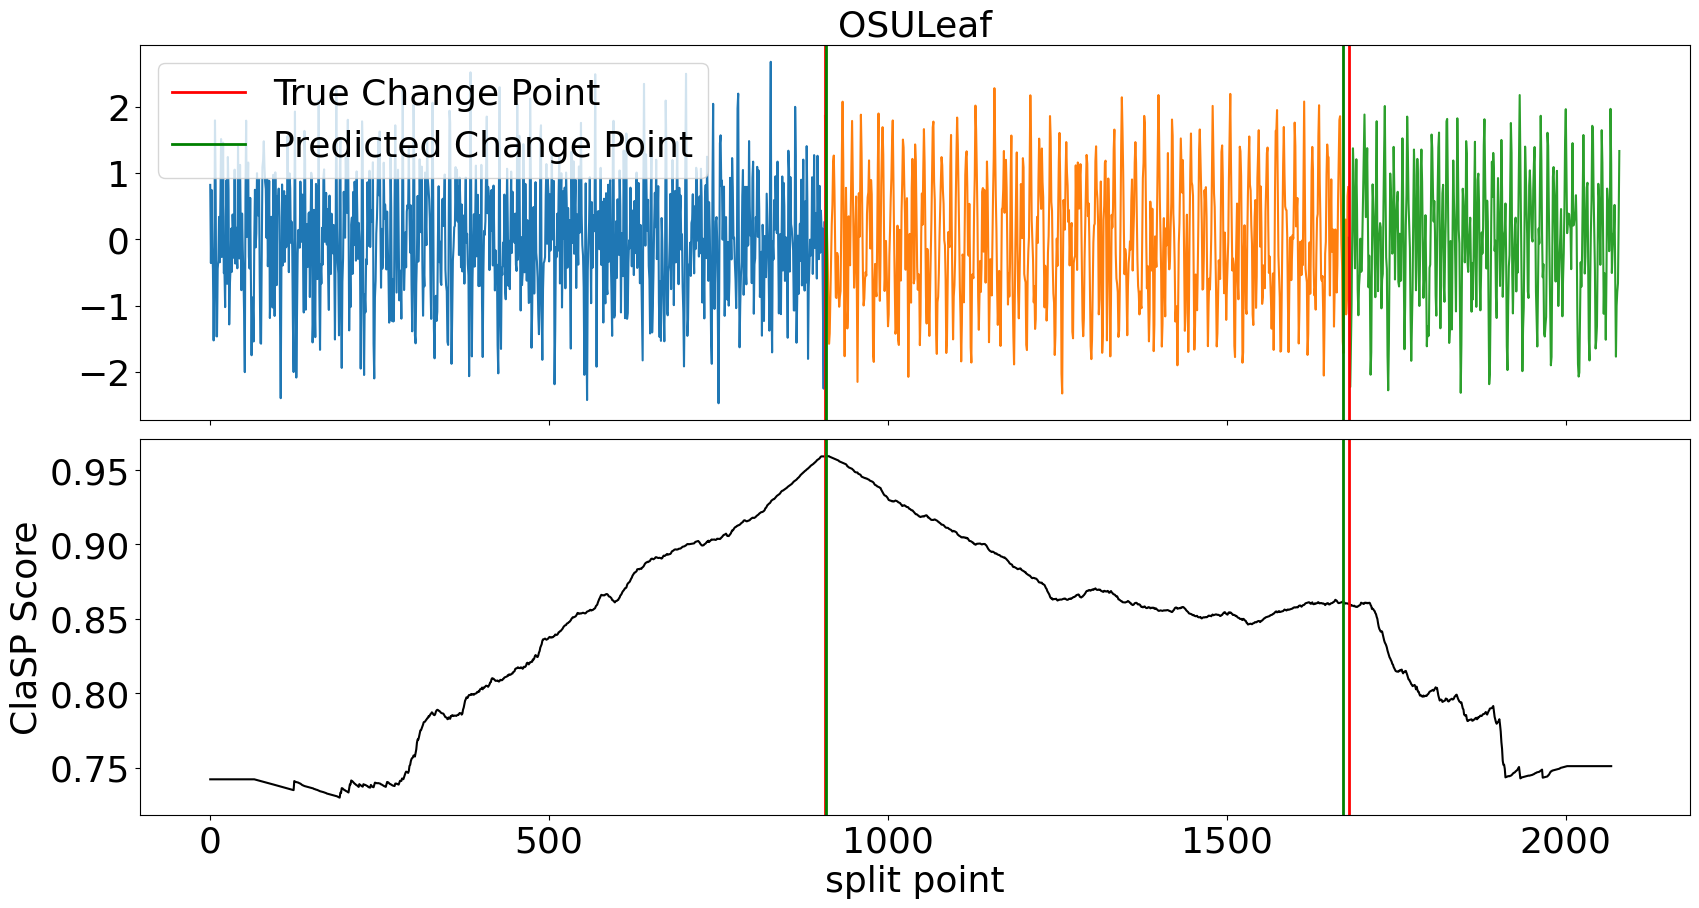

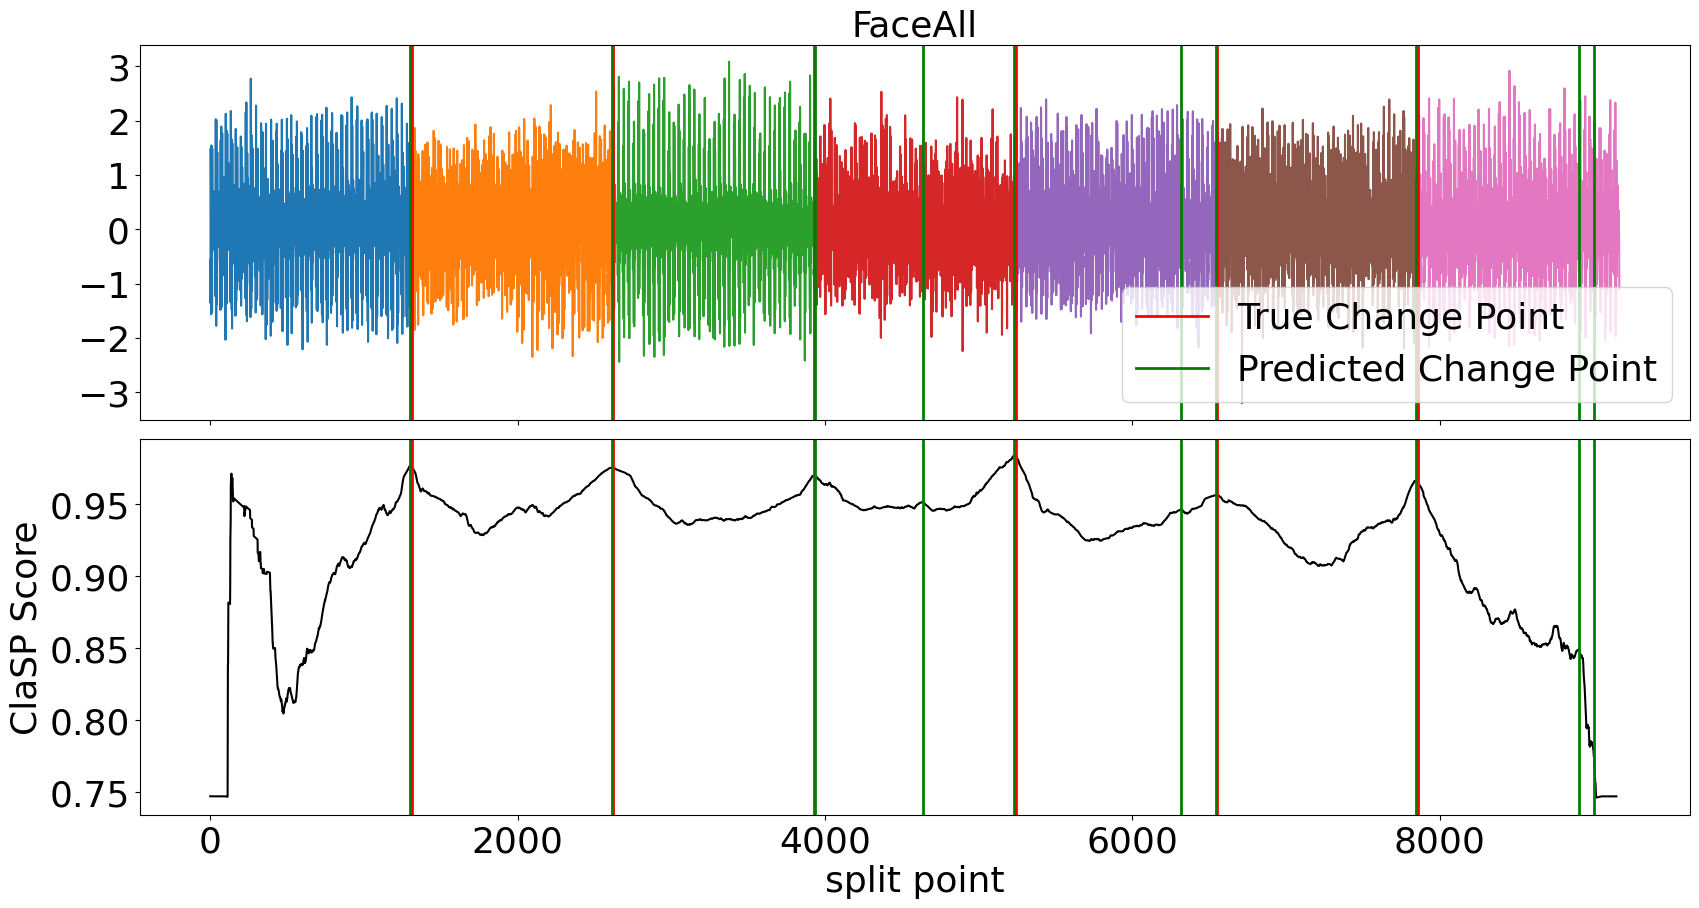

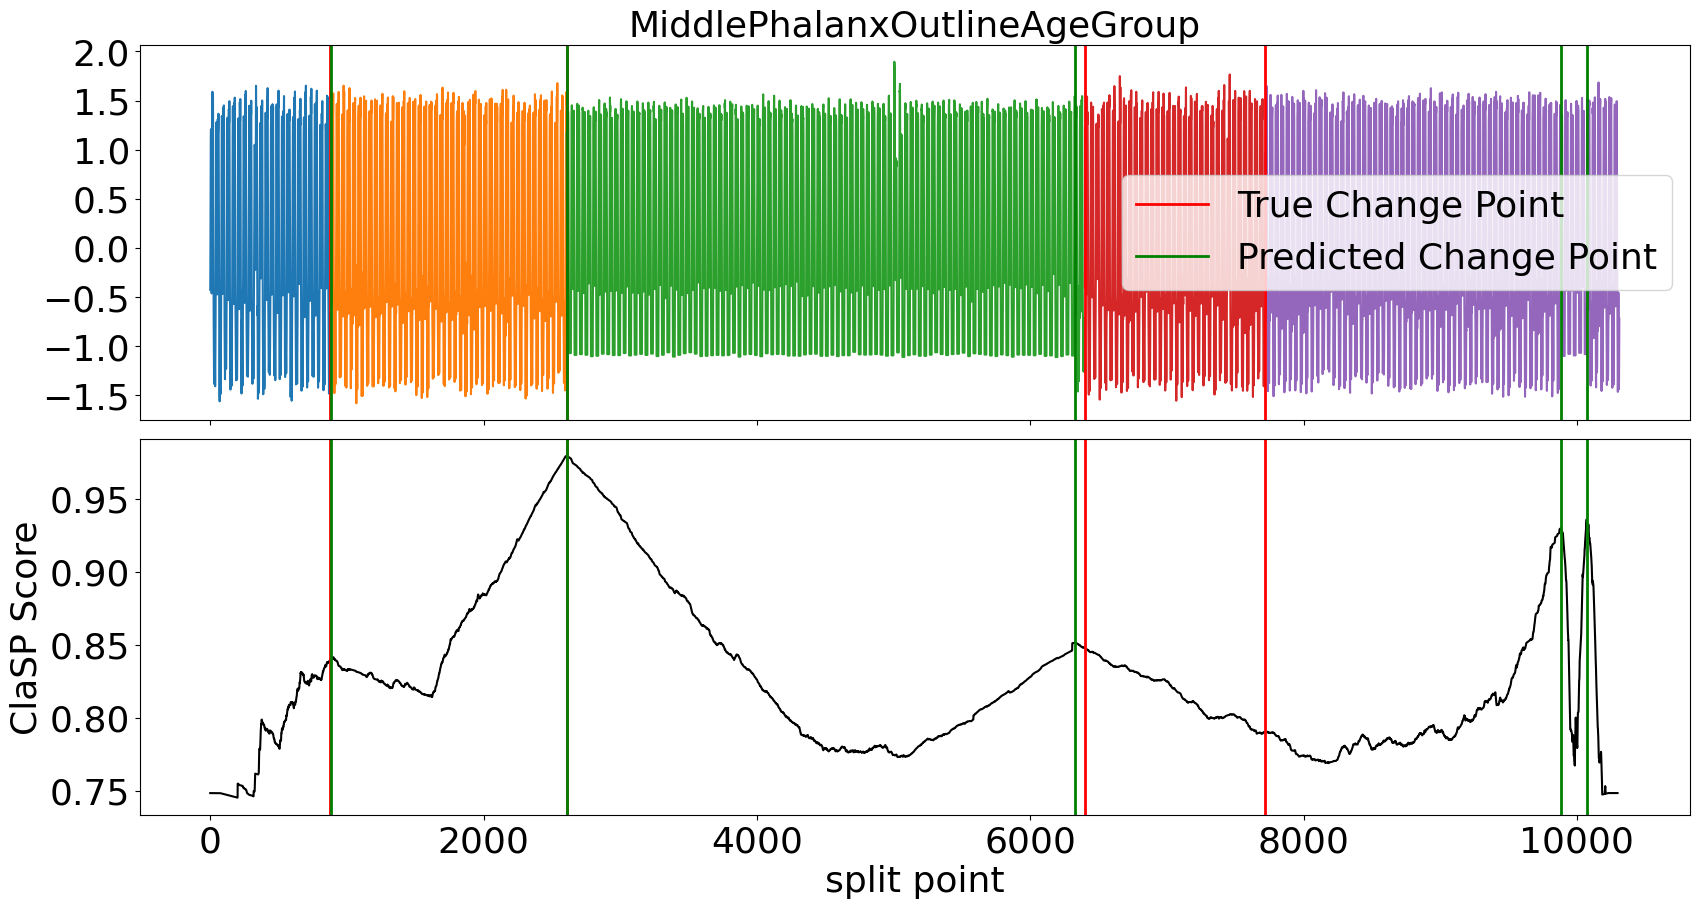

In [6]:
np.random.seed(1379)
for _, row in df.sample(5).iterrows():
    clasp = BinaryClaSPSegmentation().fit(row.time_series)
    clasp.plot(gt_cps=row.cps, heading=row.dataset)
    plt.show()

Lastly, we investigate the scalability of ClaSP.

In [7]:
df_scale = results.copy()
df_scale["len"] = df.time_series.apply(len)
df_scale["cps"] = df.cps.apply(len)
df_scale

,dataset,covering_score,runtime,len,cps
0,Adiac,0.807,10.330,1408,3
1,ArrowHead,0.985,10.265,1506,1
2,Beef,0.973,10.194,1410,1
3,BeetleFly,0.975,10.657,2560,1
4,BirdChicken,0.994,0.600,2560,1
...,...,...,...,...,...
70,UWaveGestureLibraryX,0.987,0.942,2818,4
71,UWaveGestureLibraryY,0.963,0.935,2818,4
72,UWaveGestureLibraryZ,0.810,0.877,2818,4
73,WordSynonyms,0.727,0.403,2395,2


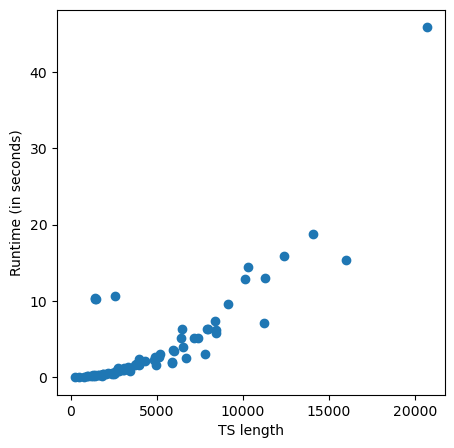

In [8]:
_, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(df_scale.len, df_scale.runtime)
ax.set_xlabel("TS length")
ax.set_ylabel("Runtime (in seconds)")
plt.show()

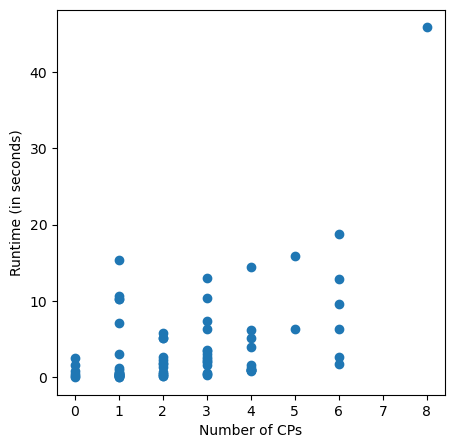

In [9]:
_, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(df_scale.cps, df_scale.runtime)
ax.set_xlabel("Number of CPs")
ax.set_ylabel("Runtime (in seconds)")
plt.show()

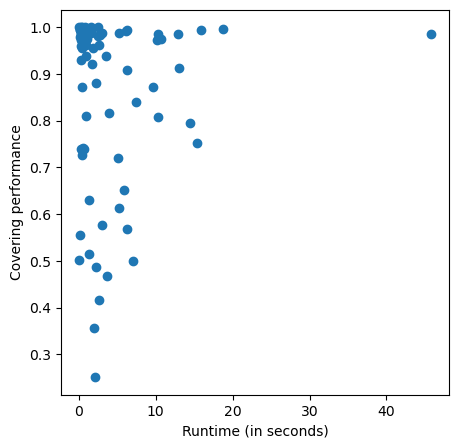

In [10]:
_, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(df_scale.runtime, df_scale.covering_score)
ax.set_xlabel("Runtime (in seconds)")
ax.set_ylabel("Covering performance")
plt.show()